In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from scipy.integrate import solve_ivp
%matplotlib inline

# Replicating Wilson, Huang, and Takagi
**Goal**: To replicate the results of Phil, Huaxiong, and Shu's paper. Similar setup to B&P, the main difference is in the interaction term.

Basic setup: A 1D domain with two population densities of lipids, $u(x)$ and $v(x)$, whose heads point in the negative and positive directions, respectively. These represent the tail distributions, so the overall tail distribution is

\begin{equation*}
\text{tails}(x) = u(x) + v(x)
\end{equation*}

The lipids are $\varepsilon$ long, so the head distribution is therefore

\begin{align*}
\text{heads} &= u(x + \varepsilon) + v(x - \varepsilon) \\
&= \tau_{-\varepsilon} u + \tau_\varepsilon v
\end{align*}

We assume incompressibility and that the rest of the space is taken up with water, so the distribution of water is given by 

\begin{equation*}
w(x) = 1 - \text{tails}(x) - \text{heads}(x) = 1 - u - v - \tau_{-\varepsilon} u - \tau_\varepsilon v
\end{equation*}

## Free energy minimisation

In B&P, the interaction term is repulsive. Proximity between tails and heads, and tails and water contributes positively to the free energy, decaying with exponentially with distance. 

In WH&T, the interation term is attractive, capturing water-water and water-head attractive forces, by having a contribution to free energy that declines with proximity. 

_I'm not sure in the definition of $\hat\kappa$ that the constant term is required. Possibly can just get by by adding a generic constant again for overall integrability of the free energy functional. Will leave it in for now, but the dependence on domain size is a bit weird_

The interaction term $\kappa$ is given by 
\begin{equation*}
\kappa(s) = \kappa_0 - \frac{1}{2\beta}e^{-|s|/\beta}
\end{equation*}

Actually, I think w.l.o.g that we can choose $\beta = 1$, essentially using our interaction distance as our spatial scale. So

\begin{equation}
\kappa(s) = \kappa_0 - \frac{1}{2}e^{-|s|}
\end{equation}

The constant $\kappa_0$ is chosen to make $\int \kappa(s)\,dx = 1$, so for a periodic domain of length $2L$, $\kappa_0 = \frac{1}{L}$

The interaction term will be 
\begin{align*}
&\alpha\left(\int w(x) (\kappa \star w)(x)\,dx + \gamma\int w(x) (\kappa \star \text{heads}(x))\,dx\right) \\ &= \alpha \int w \kappa \star (w + \gamma (\tau_{-\varepsilon}u + \tau_\varepsilon v))\,dx
\end{align*}
Subsituting in for $w(x)$, and assuming that $\gamma = 1$ (relative strengths of two effects are equal), the integral becomes
\begin{equation*}
\alpha\int(1 - u - v - \tau_{-\varepsilon}u - \tau_\varepsilon v) \kappa \star (1 - u - v)\,dx
\end{equation*}

Therefore we seek distributions $u, v$ that minimise the free energy
\begin{equation*}
F(u, v) = \int \eta(u) + \eta(v) + \alpha (1 - u - v - \tau_{-\varepsilon}u - \tau_\varepsilon v)\kappa * (1 - u - v) - \zeta(c_0)\,dx
\end{equation*}
where
\begin{equation*}
    \eta(s) = \begin{cases} 
        s \log s & \text{if } s \ge 0 \\
        \infty & \text{otherwise}
    \end{cases}
\end{equation*}
is the entropy, $0 < c_0 < \frac{1}{4}$ is the background concentration
(concentration at infinity) and $\zeta(c_0)$ is a constant for integrability (it
doesn't really matter for our purposes). The original derivations included terms
that allowed for compressibility before making the incompressibility assumption
to yield these equations.

### Conservation of mass
We also have conservation of mass
\begin{equation}
\int u + v - 2c_0 \,dx = m
\end{equation}

### Density limits
and a condition making sure we don't exceed a density of $1$:
\begin{equation*}
1 - u - \tau_{-\varepsilon} u - v - \tau_\varepsilon v \ge 0
\end{equation*}


## Euler-Lagrange equations
(_derivation currently in Apple Notes_)

The energy term is 
\begin{equation*}
E_I = \int \eta(u) + \eta(v) + \alpha(1 - u - v - \tau_{-\varepsilon}u - \tau_\varepsilon v)\kappa \star (1 - u - v) - \zeta(c_0)
\end{equation*}

By formal calculus of variations
\begin{align*}
\delta E_I &= \int \eta'(u)\delta u + \eta'(v)\delta v + \alpha(\red{-\delta u - \delta v} \green{-\delta\tau_{-\varepsilon}u - \delta \tau_\varepsilon v})\kappa \star (1 - u - v) \\
& \qquad +\alpha(1 - u - v - \tau_{-\varepsilon} u - \tau_\varepsilon v)\kappa \star (-\delta u - \delta v)
\end{align*}

We note that 

1. $\int(\delta \tau_{-\varepsilon}u)\kappa \star u\,dx = \int(\delta u(x + \varepsilon)) \kappa \star u\,dx = \int (\delta u) \kappa \star u(x - \varepsilon)\,dx = \int (\delta u) \kappa\star \tau_{\varepsilon}u\,dx$ and
2. $f(\kappa\star g) = g(\kappa \star f)$

So (colour coding to see where translation interchanges ended up)
\begin{align*}
\delta E_I &= \int \eta'(u)\delta u + \eta'(v) \delta v \\
& \qquad + \alpha(\red{-\delta u - \delta v})\kappa\star(1 - u - v) \\
& \qquad + \alpha(\green{-\delta u})\kappa \star (1 - \tau_\varepsilon u - \tau_{\varepsilon}v) \\
& \qquad + \alpha(\green{-\delta v})\kappa \star (1 - \tau_{-\varepsilon} u - \tau_{-\varepsilon} v) \\
& \qquad + \alpha(-\delta u - \delta v)\kappa\star(1 - u - v - \tau_{-\varepsilon}u - \tau_\varepsilon v)
\end{align*}
Now for some tedious collection of terms
\begin{align*}
= \int &[\eta'(u) - \alpha\kappa\star(1 - u - v) - \alpha \kappa\star(1 - \tau_\varepsilon u - \tau_{\varepsilon} v) - \alpha\kappa\star(1 - u - v - \tau_{-\varepsilon}u - \tau_\varepsilon v)]\delta u \\
+&[\eta'(v) - \alpha\kappa\star(1 - u - v) - \alpha \kappa\star(1 - \tau_{-\varepsilon} u - \tau_{-\varepsilon} v) - \alpha\kappa\star(1 - u - v - \tau_{-\varepsilon}u - \tau_\varepsilon v)]\delta v \\
= \int & \left(\log u + \alpha\kappa\star\left(2(u + v) + \tau_\varepsilon u + \tau_{-\varepsilon} u + 2\tau_{\varepsilon} v\right) + 1 - 3\alpha\right) \delta u \\
 +&\left(\log v + \alpha\kappa\star\left(2(u + v) + 2\tau_{-\varepsilon}u + \tau_{-\varepsilon}v + \tau_\varepsilon v \right) + 1 - 3\alpha\right) \delta v \\
\end{align*}

So the Euler-Lagrange equations for minimising $F(u, v)$ (including the bonus term) subject to the conservation of mass constraint are:

\begin{align*}
\log{u} + \alpha\kappa \star \left(2(u + v) + \tau_\varepsilon u + \tau_{-\varepsilon} u + 2\tau_{\varepsilon} v\right) &= \lambda - \mu - \tau_\varepsilon \mu\\
\log{v} + \alpha\kappa \star \left(2(u + v) + 2\tau_{-\varepsilon}u + \tau_{-\varepsilon}v + \tau_\varepsilon v \right) &= \lambda - \mu - \tau_{-\varepsilon} \mu \\
\end{align*}

where $\lambda$ is a Lagrange multiplier, and $\mu \in L^\infty(\mathbb{R})$ is also a Lagrange multiplier which is nonzero only where the saturation condition holds exactly. Note that the constant term $1 - 3\alpha$ is absorbed into $\lambda$ (the $1$ came from convolving $\kappa$ with $1$)

With an infinite domain, $\lambda$ can be found by looking at infinity where $\mu = 0$ and $u, v = c_0$, giving $u = v$ and hence $\lambda = \log c_0 - 4\alpha c_0$.



### Constrained gradient flow solution

We incorporate the saturation constraint $\mu = u + \tau_{-\varepsilon}u + v + \tau_\varepsilon v - 1 \le 0$ by adding a penalty term to $F(u, v)$. Blom and Peletier used a term of the form

$$
\frac{K}{2}\int (\mu_+)^2\,dx
$$

which leads to equations
\begin{align*}
u_t &= -\log u + \cdots + \lambda - K(\mu_+ + \tau_\varepsilon \mu_+) \\
v_t &= -\log v + \cdots + \lambda - K(\mu_+ + \tau_{-\varepsilon} \mu_+)
\end{align*}

where $(\cdot)_+ = \textrm{max}(0, \cdot)$. However this leads to difficulties as it makes the objective function non-differentiable, which causes problems for ODE solvers. An alternative is to instead use a logarithmic or inverse function barrier method. I feel like the latter is preferable, but we'll see. So we instead use for our penalty term

$$
K\int \frac{-1}{\mu}\,dx
$$

the idea being that it's very small unless $\mu$ is very close to zero, in which case it grows rapidly in the positive direction. Presumably things work smoothly enough during the solve that $\mu$ never jumps over the vertical asymptote. This leads to the gradient flow equations on $[-L, L]$:

\begin{align*}
u_t &= -\log{u} - \alpha\kappa \star \left(2(u + v) + \tau_\varepsilon u + \tau_{-\varepsilon} u + 2\tau_{\varepsilon} v\right) + \lambda - K\left(\frac{1}{\mu^2} + \frac{1}{\tau_\varepsilon \mu^2}\right)\\
v_t &= -\log{v} - \alpha\kappa \star \left(2(u + v) + 2\tau_{-\varepsilon}u + \tau_{-\varepsilon}v + \tau_\varepsilon v \right) + \lambda - K\left(\frac{1}{\mu^2} + \frac{1}{\tau_{-\varepsilon} \mu^2}\right)\\
\end{align*}


We cannot yet solve these numerically as the Lagrange multiplier $\lambda$ is unknown. But it makes sense we have an unknown still, we haven't taken into account conservation of mass:

We have the additional constraint that $\int u + v - 2c_0\,dx = m$, or, differentiating,
\begin{equation*}
  \int_{-L}^L u_t + v_t\,dx = 0.
\end{equation*}
So $\lambda$ can be found by solving $\int_{-L}^L u_t + v_t\,dx = 0$ for $\lambda$ (which is not dependent on $x$, so comes out of the integral)

The right hand side of the ODE system is now fully specified, and can be solved numerically.

# Solving in Python

Problem domain, parameters, interaction kernel, and initial conditions are all specified here. We're assuming periodic boundaries for now (for convenience), `convolve1d` can handle this with the `wrap` option.

If we change the boundary condition to a different type, we'll need to modify how we do the interaction

In [10]:
# Domain
L = 30
dx = 0.1
x = np.arange(-L, L + dx, dx)
N = x.shape[0]

# Parameters
eps = 5 # Needs to be a multiple of dx
K = 1e-5 # 1e-4 seems to work, the smaller the better
alpha = 3 # B&P has 4, but this doesn't give a good result
c_0 = 0.024

# Interaction kernel
x_ker = np.arange(-L, L + dx, dx)
kappa_0 = 1/L
kappa = kappa_0 - 0.5*np.exp(-np.abs(x_ker))

# Initial conditions - guassians centred on x_u and x_v with std dev sigma. 
x_u = -5
x_v = 5
sigma = 20 
m = 0.05*2*L # mass of lipids

# Constant lambda approximation
lam_star = 100
lam = -(lam_star + 1 + 3*alpha - 2*alpha*(1 - 2*c_0 - m/(2*L)))

## Perform the solve
At the moment we get a warning that `np.log` is receiving negative values. I don't think this an issue, because I think the solver then discards that step, so the issue doesn't propagate. Would appreciate confirmation of this though.

In [11]:
# Do the solve

# Set up shifting functions - using periodic boundary conditions
n_eps = int(np.round(eps/dx)) # number of grid points to shift
def tau_e_plus(y):
    return np.roll(y, n_eps)

def tau_e_minus(y):
    return np.roll(y, -n_eps)

def convolve_with_kappa(y):
    return dx*convolve1d(y, kappa, mode='wrap')

# excludes the penalty term, so represents the actual defined free energy
def free_energy(u, v):
    kuv = convolve_with_kappa(1 - u - v)
    return np.sum(u*np.log(u) + v*np.log(v) + alpha*(1 - u - v - tau_e_minus(u) - tau_e_plus(v))*kuv)*dx

def calc_lambda(u, v):
    mu = u + tau_e_minus(u) + v + tau_e_plus(v) - 1
    ku = convolve_with_kappa(2*(u + v) + tau_e_plus(u) + tau_e_minus(u) + 2*tau_e_plus(v))
    kv = convolve_with_kappa(2*(u + v) + tau_e_minus(v) + tau_e_plus(v) + 2*tau_e_minus(u))
    
    # calculate derivatives with lambda absent (c.f. equations above)
    ut_i = -np.log(u) - alpha*ku - K/mu**2 - K/(tau_e_plus(mu)**2)
    vt_i = -np.log(v) - alpha*kv - K/mu**2 - K/(tau_e_minus(mu)**2)
    
    # Total change in ut and vt should be zero (conservation of mass)
    return -(np.sum(ut_i) + np.sum(vt_i))/(2*N)
    
def rhs_wht(t, y):
    u = y[:N]
    v = y[N:]
    
    # mu = K*np.maximum(u + tau_e_minus(u) + v + tau_e_plus(v) - 1, 0)
    mu = u + tau_e_minus(u) + v + tau_e_plus(v) - 1
    ku = convolve_with_kappa(2*(u + v) + tau_e_plus(u) + tau_e_minus(u) + 2*tau_e_plus(v))
    kv = convolve_with_kappa(2*(u + v) + tau_e_minus(v) + tau_e_plus(v) + 2*tau_e_minus(u))
    
    # calculate derivatives with lambda absent (c.f. equations above)
    ut_i = -np.log(u) - alpha*ku - K/mu**2 - K/(tau_e_plus(mu)**2)
    vt_i = -np.log(v) - alpha*kv - K/mu**2 - K/(tau_e_minus(mu)**2)
    
    # Total change in ut and vt should be zero (conservation of mass)
    # lam = -(np.sum(ut_i) + np.sum(vt_i))/(2*N)
    
    # Actual derivatives need lambda added on
    return np.concatenate((ut_i + lam, vt_i + lam))

# Published version differs in the convolution terms - seem to be reversed from my one. Not sure if it's stemmed from confusion of \tau_e u = u(x - e)
def rhs_wht_published(t, y):
    u = y[:N]
    v = y[N:]
    
    # mu = K*np.maximum(u + tau_e_minus(u) + v + tau_e_plus(v) - 1, 0)
    mu = u + tau_e_minus(u) + v + tau_e_plus(v) - 1
    ku = convolve_with_kappa(2*(u + v) + 2*tau_e_minus(u) + tau_e_minus(v) + tau_e_plus(v))
    kv = convolve_with_kappa(2*(u + v) + tau_e_minus(u) + tau_e_plus(u) + 2*tau_e_plus(v))
    
    # calculate derivatives with lambda absent (c.f. equations above)
    ut_i = -np.log(u) + alpha*ku - K/mu**2 - K/(tau_e_plus(mu)**2)
    vt_i = -np.log(v) + alpha*kv - K/mu**2 - K/(tau_e_minus(mu)**2)
    
    # Total change in ut and vt should be zero (conservation of mass)
    lam = -(np.sum(ut_i) + np.sum(vt_i))/(2*N)
    
    # Actual derivatives need lambda added on
    return np.concatenate((ut_i + lam, vt_i + lam))

# Initial conditions
u0 = c_0 + m/(2*sigma*np.sqrt(np.pi))*np.exp(-0.5*((x - x_u)/sigma)**2)
v0 = c_0 + m/(2*sigma*np.sqrt(np.pi))*np.exp(-0.5*((x - x_v)/sigma)**2)
y0 = np.concatenate((u0, v0))

soln = solve_ivp(rhs_wht, (0, 2), y0, method='Radau')

# Calculate the free energy over the solution
F = np.array([free_energy(y[:N], y[N:]) for y in soln.y.T])

# Calculate the labmda value over the solution
L = np.array([calc_lambda(y[:N], y[N:]) for y in soln.y.T])

M = np.array([sum(y)-2*c_0 for y in soln.y.T])




/var/folders/6f/vgnjt9l93296jgknw1rh37tm0000gn/T/ipykernel_65802/811195052.py:41: RuntimeWarning: invalid value encountered in log
  ut_i = -np.log(u) - alpha*ku - K/mu**2 - K/(tau_e_plus(mu)**2)
/var/folders/6f/vgnjt9l93296jgknw1rh37tm0000gn/T/ipykernel_65802/811195052.py:42: RuntimeWarning: invalid value encountered in log
  vt_i = -np.log(v) - alpha*kv - K/mu**2 - K/(tau_e_minus(mu)**2)


## Plot the results

Text(0.5, 1.0, 'Mass: should be constant')

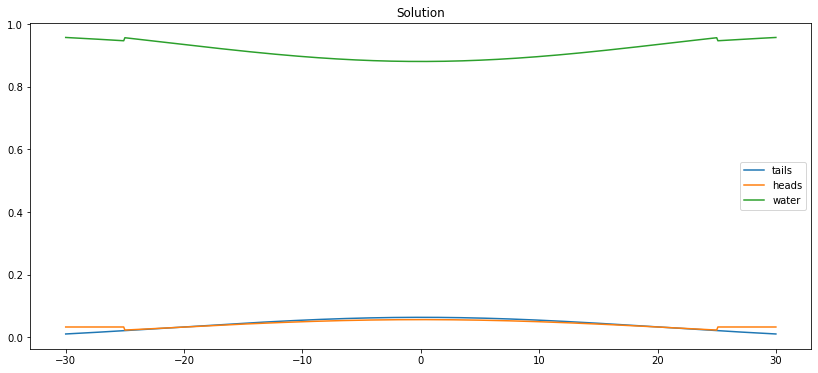

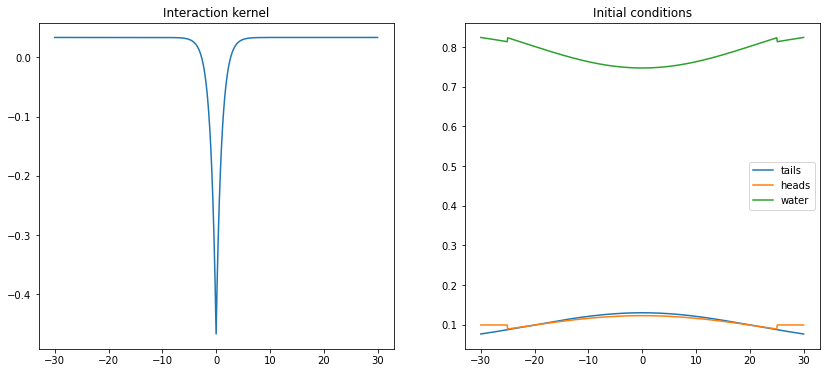

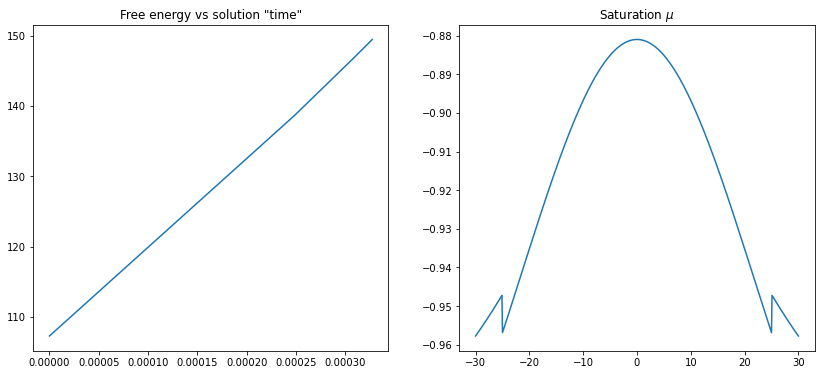

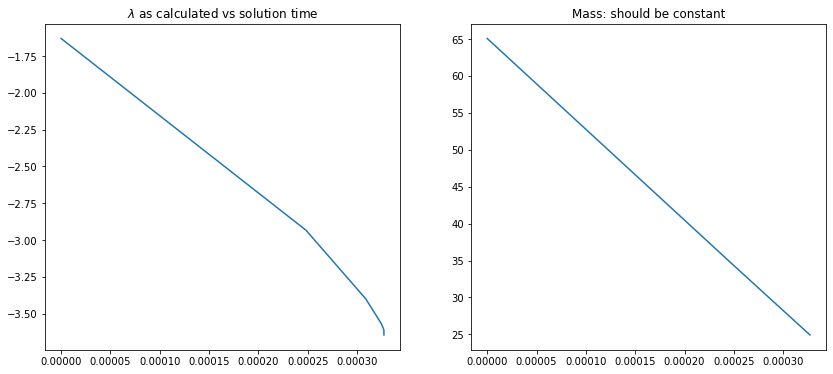

In [12]:
# Plot everything
def plot_solution(u, v):
    tails = u + v
    heads = tau_e_minus(u) + tau_e_plus(v)
    water = 1 - heads - tails
    plt.plot(x, tails, x, heads, x, water)
    plt.legend(('tails', 'heads', 'water'))

plt.figure(figsize=(14, 6))
u = soln.y[:N, -1]
v = soln.y[N:, -1]
plot_solution(u, v)
plt.title('Solution')

plt.subplots(1,2, figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(x_ker, kappa)
plt.title("Interaction kernel")

plt.subplot(1,2,2)
plot_solution(u0, v0)
plt.title('Initial conditions')

plt.subplots(1,2, figsize=(14, 6))
plt.subplot(1,2,1)
plt.plot(soln.t, F)
plt.title("Free energy vs solution \"time\"")

mu = u + tau_e_minus(u) + v + tau_e_plus(v) - 1
plt.subplot(1,2,2)
plt.plot(x, mu)
plt.title("Saturation $\mu$")

plt.subplots(1, 2, figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(soln.t, L)
plt.title("$\lambda$ as calculated vs solution time")
M = np.array([sum(y)-2*c_0 for y in soln.y.T])
plt.subplot(1,2,2)
plt.plot(soln.t, M)
plt.title("Mass: should be constant")